In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from tqdm import tqdm
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

In [7]:
# read data
ndvi_path="lucas_soil_ndvi_new8_postive.csv"
ci_path="lucas_soil_CI_new8_postive.csv"
ndmi_path="lucas_soil_ndmi_new8_postive.csv"
EVI_path="lucas_soil_EVI_new8_postive.csv"

ndvi_df=pd.read_csv(ndvi_path)
ci_df=pd.read_csv(ci_path)
ndmi_df=pd.read_csv(ndmi_path)
EVI_df=pd.read_csv(EVI_path)
msavi_df=pd.read_csv("lucas_soil_MSAVI2_new8_postive.csv")
weather_df=pd.read_csv("weather_data.csv")


# drop rows with missing values
ndvi_df = ndvi_df.dropna(subset=['Mean'])
ci_df = ci_df.dropna(subset=['Mean'])
ndmi_df = ndmi_df.dropna(subset=['Mean'])
EVI_df = EVI_df.dropna(subset=['Mean'])
msavi_df = msavi_df.dropna(subset=['Mean'])






df = pd.DataFrame()  # Define the variable df
df["POINTID"] = ndvi_df["POINTID"]
ci_df["ci"] = ci_df["Mean"]
ndvi_df["ndvi"] = ndvi_df["Mean"]
ndmi_df["ndmi"] = ndmi_df["Mean"]
msavi_df["msavi2"] = msavi_df["Mean"]

EVI_df["evi"] = EVI_df["Mean"]

df["N_level"] = ""  # Initialize the 'N_level' column
df["POINTID"] = ci_df["POINTID"]



df = df.join(weather_df.set_index('ID')[["season","climate","soil_water_all","soil_temp_all"]], on='POINTID')
df = df.join(ci_df.set_index('POINTID')[["ci"]], on='POINTID')
df = df.join(ndvi_df.set_index('POINTID')[["ndvi"]], on='POINTID')
df = df.join(EVI_df.set_index('POINTID')[["evi"]], on='POINTID')
df = df.join(ndmi_df.set_index('POINTID')[["ndmi"]], on='POINTID')
df = df.join(msavi_df.set_index('POINTID')[["msavi2"]], on='POINTID')

#catboost encoding
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import OneHotEncoder
df["N"] = ndvi_df["N"]



#catboost encoding
#encoder = CatBoostEncoder(cols=['climate'], verbose=0)
#encoded_df = encoder.fit_transform(df['climate'], df['N'])
#df = pd.concat([df.drop(columns=['climate']), pd.DataFrame(encoded_df)], axis=1)





#one hot encoding 
df=df.dropna(subset=['season'])
#climate one-hot encoded
#season one-hot encoded

onehot_encoder = OneHotEncoder(sparse=False,min_frequency=None)
climate_encoded = onehot_encoder.fit_transform(df[['climate']])
climate_encoded_df = pd.DataFrame(climate_encoded, columns=onehot_encoder.get_feature_names_out(['climate']))
climate_encoded_df.index = df.index
df = df.drop(columns=['climate']).join(pd.DataFrame(climate_encoded_df))


#season one-hot encoded

onehot_encoder = OneHotEncoder(sparse=False)
season_encoded = onehot_encoder.fit_transform(df[['season']])
season_encoded_df = pd.DataFrame(season_encoded, columns=onehot_encoder.get_feature_names_out(['season']))
season_encoded_df.index = df.index
df = df.drop(columns=['season']).join(pd.DataFrame(season_encoded_df))

df = df[df["evi"] <= 3]

df.reset_index(drop=True, inplace=True)

#df = df.dropna(subset=['ndvi_mean'])
df = df.dropna(subset=['ndmi'])
df = df.dropna(subset=['evi'])
#df = df.dropna(subset=['climate'])
#df=df.dropna(subset=['soil_water_all'])
#df=df.dropna(subset=['msavi_mean'])

# set up high and low Nitrogen

for i in range(len(df)):
    if df["N"].iloc[i] >= df["N"].quantile(0.8):
        df["N_level"].iloc[i] = 2

    elif df["N"].iloc[i] >= df["N"].quantile(0.25):
        df["N_level"].iloc[i] = 1
            
    else:
        df["N_level"].iloc[i] = 0

csv_file_path = "vegetation_data.csv"

# Write the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)

c:\Users\Jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Jacob\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Jacob\AppData\Local\Temp\ipykernel_19320\3620678553.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["N_level"].iloc[i] = 1
C:\Users\Jacob\AppData\Local\Temp\ipykernel_19320\3620678553.py:99: SettingWithCopyWarning: 
A value is trying to be set on a 

In [8]:

y = df["N"].astype(int)


# adding a noise column to the data in order to test the feature importance
noise = np.random.normal(0, 3, df.shape[0])

df["noise"] = noise

X = df.drop(["N_level", "N","POINTID"], axis=1)

#fixing problem where EVI data has "inf" values




scaler = StandardScaler()
numeric_features = X.columns[:7]


# Standardize the first 7 features
X[numeric_features] = scaler.fit_transform(X[numeric_features])

xgboost = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.1)
rf_reg = RandomForestRegressor(max_depth=3, max_features=2, n_estimators=1000,random_state=33,min_samples_leaf=10)
grad_reg = GradientBoostingRegressor(max_depth=50, max_features=25, n_estimators=1000,random_state=33)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=3)
#Xr_train, Xr_test, yr_train, yr_test = train_test_split(X, yr, test_size=0.2, random_state=50)





rf_reg.fit(X_train, y_train)
grad_reg.fit(X_train, y_train)
xgboost.fit(X_train, y_train)

y_pred = rf_reg.predict(X_test)
g_pred = grad_reg.predict(X_test)
xgb_pred = xgboost.predict(X_test)

baseline = np.mean(y_test)
baseline_predictions = np.full((len(y_test),), baseline)



regressor_mae = metrics.mean_absolute_error(y_test, y_pred)
print(f"random forest regressor mean abs error: {regressor_mae:.2f}")

grad_mae = metrics.mean_absolute_error(y_test, g_pred)
print(f"gradient boosting regressor mean abs error: {grad_mae:.2f}")

xgb_mae = metrics.mean_absolute_error(y_test, xgb_pred)
print(f"xgboost regressor mean abs error: {xgb_mae:.2f}")


baseline_mae = metrics.mean_absolute_error(baseline_predictions, y_test)
print(f"Baseline mean abs error: {baseline_mae:.2f}")



random forest regressor mean abs error: 0.60
gradient boosting regressor mean abs error: 0.74
xgboost regressor mean abs error: 0.66
Baseline mean abs error: 0.61


Feature: soil_water_all, Importance: 0.1399983245921423
Feature: soil_temp_all, Importance: 0.14429068149799362
Feature: ci, Importance: 0.07734464816304149
Feature: ndvi, Importance: 0.07398724415134192
Feature: evi, Importance: 0.0
Feature: ndmi, Importance: 0.08763326521672732
Feature: msavi2, Importance: 0.10214149631478259
Feature: climate_BSk, Importance: 0.0
Feature: climate_Cfa, Importance: 0.007694204209572865
Feature: climate_Cfb, Importance: 0.023643946389209577
Feature: climate_Csa, Importance: 0.002524372135346132
Feature: climate_Csb, Importance: 0.11990556867853758
Feature: climate_Dfb, Importance: 0.10317809352392782
Feature: climate_Dfc, Importance: 0.0
Feature: season_Fall, Importance: 0.007169524580816819
Feature: season_Spring, Importance: 0.01249053062490722
Feature: season_Summer, Importance: 0.019732384862964317
Feature: noise, Importance: 0.07826571505868837
Index(['soil_water_all', 'soil_temp_all', 'ci', 'ndvi', 'evi', 'ndmi',
       'msavi2', 'climate_BSk', 'c

<Figure size 2000x1000 with 0 Axes>

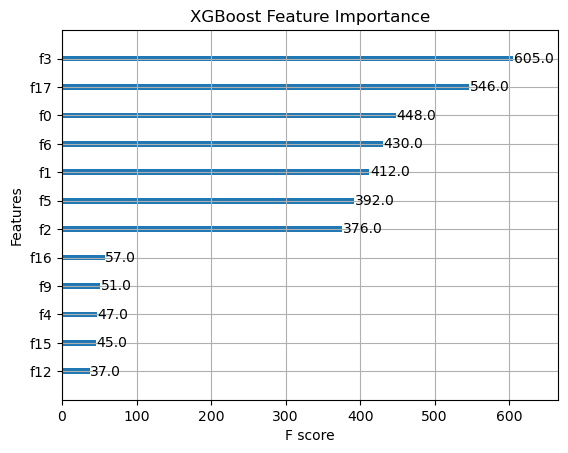

In [6]:
# feature importance
importances = rf_reg.feature_importances_

feature_names = df.drop(["N_level", "N","POINTID"], axis=1).columns
# Print the feature importances
for feature_name, importance in zip(feature_names, importances):
    print(f"Feature: {feature_name}, Importance: {importance}")

feature_names.tolist()
print(feature_names)
#for xgboost

plt.figure(figsize=(20, 10))  # Adjust figure size as needed
xgb.plot_importance(xgboost, max_num_features=12)
#plt.gca().set_yticklabels(feature_names)
plt.title("XGBoost Feature Importance")

plt.show()

In [7]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rf_reg, X ,y , n_repeats=30, random_state=0)


for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{feature_names[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")
        


soil_temp_all0.015 +/- 0.002
climate_Dfb0.014 +/- 0.002
soil_water_all0.014 +/- 0.002
climate_Csb0.014 +/- 0.003
ci      0.007 +/- 0.002
msavi2  0.007 +/- 0.001
ndvi    0.006 +/- 0.001
noise   0.006 +/- 0.001
ndmi    0.006 +/- 0.001
climate_Cfb0.005 +/- 0.001
season_Summer0.001 +/- 0.000
season_Spring0.001 +/- 0.000
season_Fall0.000 +/- 0.000


In [8]:
rf_reg.score(X, y)




0.072107516568652

In [9]:
classifier_accuracy = accuracy_score(yc_test, yc_pred)
print(f"Classifier accuracy: {classifier_accuracy:.2f}")

regressor_mae = metrics.mean_squared_error(yr_pred, yr_test)
print(f"Regressor mean squared error: {regressor_mae:.2f}")

baseline_mae = metrics.mean_squared_error(baseline_predictions, yr_test)
print(f"Baseline mean squared error: {baseline_mae:.2f}")


conf_matrix = confusion_matrix(yc_test, yc_pred)
class_labels = ["Low Nitrogen", "moderate nitrogen", "high nitrogen"]  # Example labels

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

NameError: name 'yc_test' is not defined